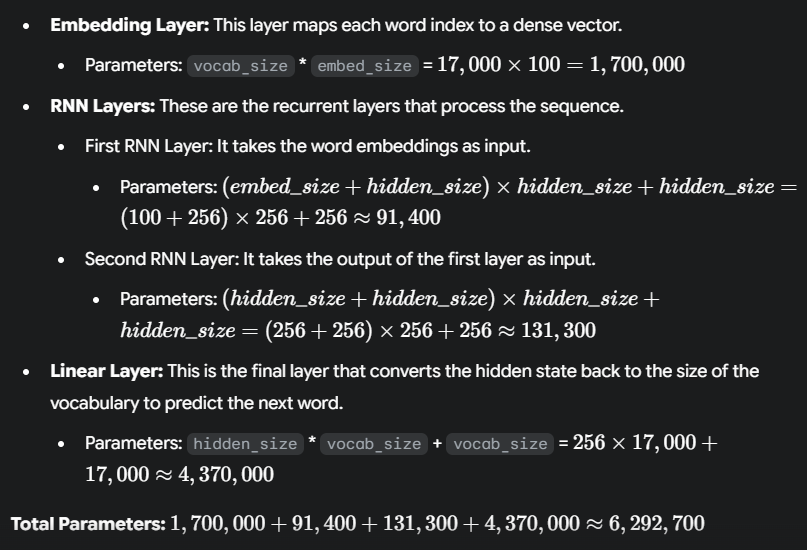

In [2]:
# Importing Required Packages
import torch
import torch.nn as nn
import requests
import re
from collections import Counter
from torch.nn import functional as F
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download the new corpus (Moby Dick)
url = 'https://github.com/poloclub/Fine-tuning-LLMs/blob/main/data/hawaii_wf_1.txt'
response = requests.get(url)
raw_text = response.text

In [4]:
# Clean and tokenize the text
text = raw_text.lower()
text = re.sub(r'[^a-z\s]+', '', text)  # Remove non-alphabetic characters
words = text.split()

In [5]:
# Build the vocabulary and word mappings
word_counts = Counter(words)
sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
vocab_size = len(sorted_vocab)

word_to_idx = {word: i for i, word in enumerate(sorted_vocab)}
idx_to_word = {i: word for i, word in enumerate(sorted_vocab)}

# Convert the corpus to a sequence of indices
corpus_indices = [word_to_idx[word] for word in words]

# Get the Vocab size
print("The Vocabulary length is:", vocab_size)

The Vocabulary length is: 2084


In [6]:
# The Model Class (with corrected init_hidden)
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x, hidden):
        embeds = self.embedding(x)
        out, hidden = self.rnn(embeds, hidden)
        out = out.reshape(-1, out.shape[2])
        out = self.linear(out)
        return out, hidden

    # CORRECTED: init_hidden now takes a batch_size argument
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

In [7]:
# Training Function with Early Stopping and Model Saving
def train_model(model, train_indices, val_indices, epochs, lr, patience = 50, save_path = r"C:\Users\Webbies\Jupyter_Notebooks\Trying_Different_Models\SLMs\rnn_model.pth"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    batch_size = 128
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        total_loss = 0
        hidden = model.init_hidden(batch_size)

        for i in range(0, len(train_indices) - 1, batch_size):
            x_indices = train_indices[i:i+batch_size]
            y_indices = train_indices[i+1:i+1+batch_size]
            if len(x_indices) != batch_size:
                continue

            x = torch.tensor(x_indices, dtype=torch.long)
            y = torch.tensor(y_indices, dtype=torch.long)

            hidden = hidden.detach()
            optimizer.zero_grad()

            outputs, hidden = model(x.unsqueeze(1), hidden)
            loss = criterion(outputs, y)

            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / (len(train_indices) / batch_size)

        # ---- Validation ----
        model.eval()
        val_loss = 0
        hidden = model.init_hidden(batch_size)
        with torch.no_grad():
            for i in range(0, len(val_indices) - 1, batch_size):
                x_indices = val_indices[i:i+batch_size]
                y_indices = val_indices[i+1:i+1+batch_size]
                if len(x_indices) != batch_size:
                    continue

                x = torch.tensor(x_indices, dtype=torch.long)
                y = torch.tensor(y_indices, dtype=torch.long)

                outputs, hidden = model(x.unsqueeze(1), hidden)
                loss = criterion(outputs, y)
                val_loss += loss.item()

        avg_val_loss = val_loss / (len(val_indices) / batch_size)

        print(f"Epoch [{epoch+1}/{epochs}] , Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # ---- Early Stopping Logic ----
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"New best model saved at epoch {epoch+1} with val loss {avg_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement. Patience {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")
                break

    print(f"Training complete. Best model saved to {save_path}")

In [8]:
# Hyperparameters
embed_size = 100
hidden_size = 256
num_layers = 4
epochs = 100  # Start with a small number of epochs, increase for better results
lr = 0.0001

In [9]:
# Instantiate the model
model = RNNModel(vocab_size, embed_size, hidden_size, num_layers)

In [10]:
# Train the model with the new, larger corpus: Example 80/20 split
split = int(0.8 * len(corpus_indices))
train_indices = corpus_indices[:split]
val_indices = corpus_indices[split:]

# Train the model with validation
train_model(model, train_indices, val_indices, epochs, lr)

Epoch [1/100] , Train Loss: 7.4620, Val Loss: 7.4276
New best model saved at epoch 1 with val loss 7.4276
Epoch [2/100] , Train Loss: 6.3665, Val Loss: 7.5059
No improvement. Patience 1/50
Epoch [3/100] , Train Loss: 5.8400, Val Loss: 7.7878
No improvement. Patience 2/50
Epoch [4/100] , Train Loss: 5.6990, Val Loss: 7.9158
No improvement. Patience 3/50
Epoch [5/100] , Train Loss: 5.5837, Val Loss: 7.9195
No improvement. Patience 4/50
Epoch [6/100] , Train Loss: 5.4266, Val Loss: 7.9026
No improvement. Patience 5/50
Epoch [7/100] , Train Loss: 5.2491, Val Loss: 7.8881
No improvement. Patience 6/50
Epoch [8/100] , Train Loss: 5.0728, Val Loss: 7.8514
No improvement. Patience 7/50
Epoch [9/100] , Train Loss: 4.8964, Val Loss: 7.8130
No improvement. Patience 8/50
Epoch [10/100] , Train Loss: 4.7327, Val Loss: 7.7723
No improvement. Patience 9/50
Epoch [11/100] , Train Loss: 4.5830, Val Loss: 7.7272
No improvement. Patience 10/50
Epoch [12/100] , Train Loss: 4.4487, Val Loss: 7.6941
No impr

In [11]:
# Loading the best Model
model.load_state_dict(torch.load(r"C:\Users\Webbies\Jupyter_Notebooks\Trying_Different_Models\SLMs\rnn_model.pth"))
model.eval()

RNNModel(
  (embedding): Embedding(2084, 100)
  (rnn): RNN(100, 256, num_layers=4, batch_first=True)
  (linear): Linear(in_features=256, out_features=2084, bias=True)
)

In [12]:
# Function used to generate Texts
def generate_text(model, seed_text, num_words, top_k=10):
    model.eval()
    text = seed_text.lower().split()

    if not text:
        return ""

    seed_indices = [word_to_idx.get(w) for w in text if w in word_to_idx]

    if not seed_indices:
        return "Seed words not in vocabulary."

    current_word_idx = seed_indices[-1]
    generated_indices = [current_word_idx]
    hidden = model.init_hidden(batch_size=1)

    with torch.no_grad():
        for _ in range(num_words):
            x = torch.tensor([[current_word_idx]], dtype=torch.long)
            hidden = hidden.detach()

            output, hidden = model(x, hidden)
            probabilities = F.softmax(output, dim=1).squeeze()

            top_k_prob, top_k_idx = torch.topk(probabilities, top_k)
            predicted_idx = top_k_idx[torch.multinomial(top_k_prob, 1)].item()

            current_word_idx = predicted_idx
            generated_indices.append(predicted_idx)

    return ' '.join(idx_to_word.get(idx, '[UNK]') for idx in generated_indices)

In [13]:
# Example usage (after training)
generated_sentence = generate_text(model, "Maui", num_words = 15)
print(f"Generated sentence: {generated_sentence}")

Generated sentence: maui a classocticon div a viewbox ariahiddentrue dm la div dataviewcomponenttrue div div la classocticon a
